In [1]:
import random
import numpy as np
import csv
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime

In [2]:
DJdf = pd.read_csv("./../stock_data/djia_2012.csv", header=0, names=["Date", "Avg"])
Nasdf = pd.read_csv("./../stock_data/nasdaq_all.csv")
Russdf = pd.read_csv("./../stock_data/russel2000_all.csv")

DJdf["Date"] = pd.to_datetime(DJdf["Date"])
DJdf["Date"] = DJdf["Date"].apply(lambda x: x.toordinal())

## Local Outlier Factor without Novelty

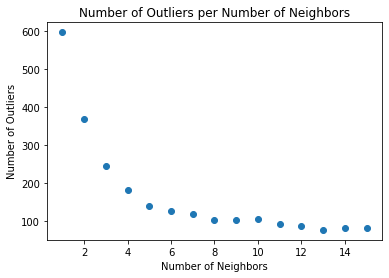

In [3]:
x = []
y = []
for i in range(1,16):
    clf = LocalOutlierFactor(n_neighbors=i)
    pred = clf.fit_predict(DJdf.to_numpy())
    outliers = np.count_nonzero(np.where(pred == -1))
    x.append(i)
    y.append(outliers)
plt.scatter(x,y)
plt.title('Number of Outliers per Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Number of Outliers');

In [4]:
def graphOutliers(neighbors = 2):
    clf = LocalOutlierFactor(n_neighbors=neighbors)
    pred = clf.fit_predict(DJdf.to_numpy())
    outliers = np.nonzero(pred == -1)
    plt.figure(figsize=(16,9))
    plt.scatter(DJdf["Date"], DJdf["Avg"])
    plt.scatter(DJdf["Date"].to_numpy()[outliers], DJdf["Avg"].to_numpy()[outliers], c="red")
    plt.title('DJ Data with Outliers in Red')

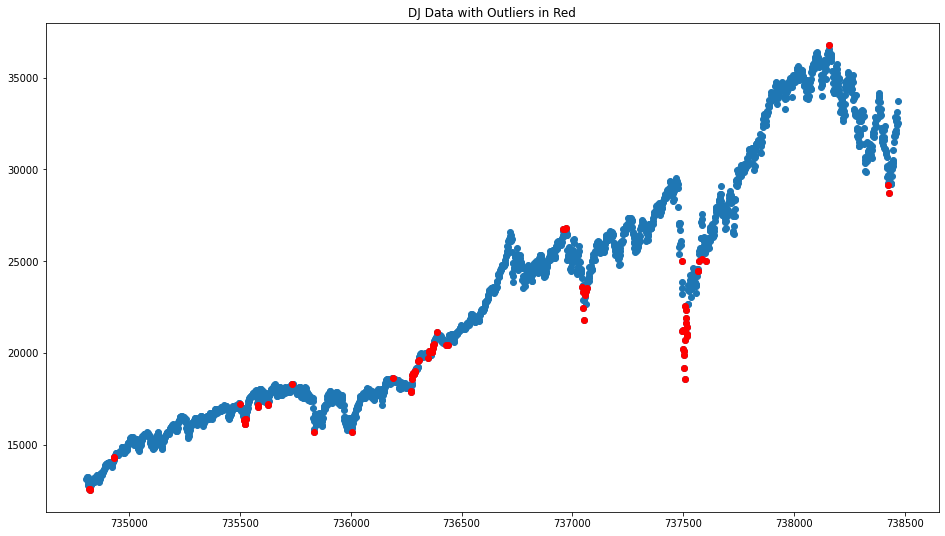

In [5]:
graphOutliers(20)

## Local Outlier Factor Window Implementation

In [6]:
def windowLOF(n, window, nextWindow):
    if int(window.size/2) < n:
        n = int(window.size/2)
    clf = LocalOutlierFactor(n_neighbors=n, novelty=True)
    clf.fit(window)
    pred = clf.predict(nextWindow)
    outliers = np.nonzero(pred == -1)
    return pred, outliers

def windowOutlierDetection(allData, windowSize, nn, delete=False):
    collectedOutliers = np.array([0])
    start, dataSize = windowSize, len(allData)
    if windowSize > dataSize:
        raise Exception('Step size must be smaller than the amount of data')
    currentWindow = allData[0:windowSize]
    while True:
        end = start + windowSize
        if end > dataSize:
            end = dataSize
        nextWindow = allData[start:end]
        pred, outliers = windowLOF(nn, currentWindow, nextWindow)
        if start == windowSize:
            collectedOutliers = outliers
        else:
            collectedOutliers = np.append(collectedOutliers, np.add(outliers, start))
        if end >= dataSize:
            break
        
        start = end
        if delete:
            tWindow = np.delete(nextWindow, outliers, 0)
            if tWindow.size != 0:
                currentWindow = tWindow
        else:
            currentWindow = nextWindow
    return collectedOutliers

def graphDJOutliers(df, outliers, n, title=''):
    plt.figure(figsize=(16,9))
    if title == '':
        plt.title('DJ Data : Novelty LOF with {} Neighbors'.format(n))
    else:
        plt.title(title)
    plt.scatter(df["Date"], df["Avg"])
    plt.scatter(df["Date"].to_numpy()[outliers], df["Avg"].to_numpy()[outliers], c="red")

def graphDJOutliersNP(data, outliers, n, title=''):
    plt.figure(figsize=(16,9))
    if title == '':
        plt.title('DJ Data : Novelty LOF with {} Neighbors'.format(n))
    else:
        plt.title(title)
    plt.scatter(data[:,0], data[:,1])
    plt.scatter(data[:,0][outliers], data[:,1][outliers], c="red")

## Validation

False Positives: 218
Accuracy: 91.4%


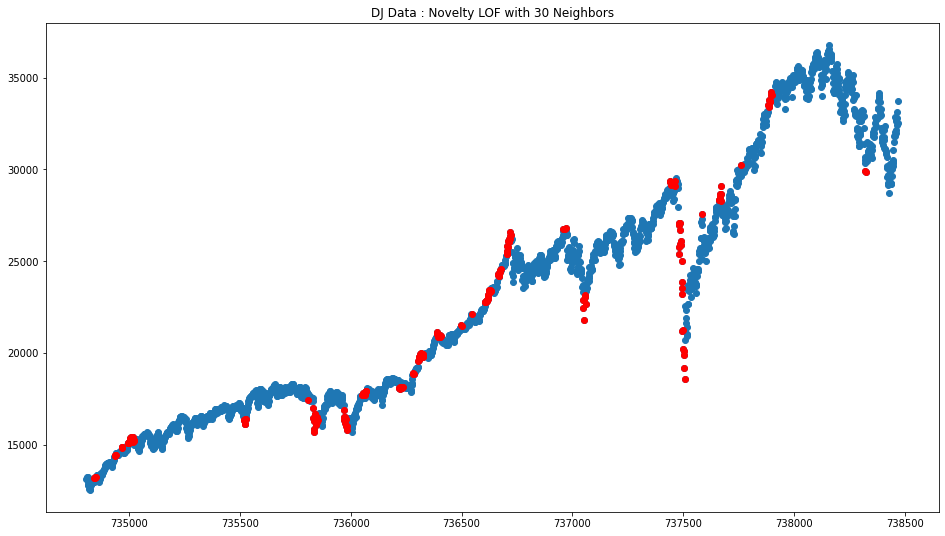

In [7]:
n = 30
outliers = windowOutlierDetection(DJdf.to_numpy(), 30, n, False)
graphDJOutliers(DJdf, outliers, n)
falsePositives = outliers.size
dataSize = DJdf.size/2
print('False Positives: {}'.format(falsePositives))
print('Accuracy: {0:.1%}'.format((dataSize-falsePositives)/dataSize))

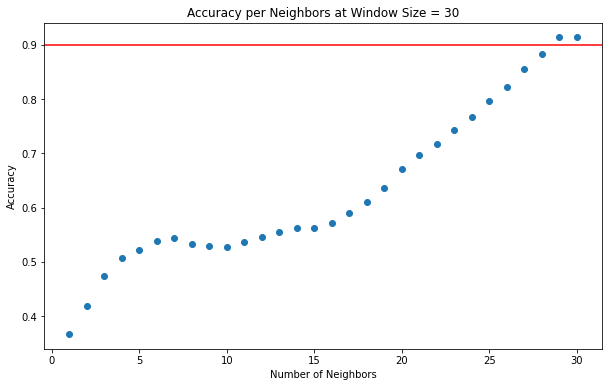

In [8]:
x = []
y = []
for i in range(1,31):
    outliers = windowOutlierDetection(DJdf.to_numpy(), 30, i)
    falsePositives = outliers.size
    dataSize = DJdf.size/2
    x.append(i)
    y.append((dataSize-falsePositives)/dataSize)
plt.figure(figsize=(10,6))
plt.scatter(x,y)
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.title('Accuracy per Neighbors at Window Size = 30')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy');

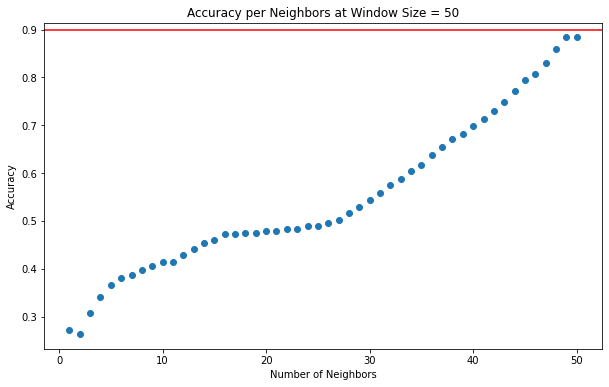

In [9]:
x = []
y = []
for i in range(1,51):
    outliers = windowOutlierDetection(DJdf.to_numpy(), 50, i)
    falsePositives = outliers.size
    dataSize = DJdf.size/2
    x.append(i)
    y.append((dataSize-falsePositives)/dataSize)
plt.figure(figsize=(10,6))
plt.scatter(x,y)
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.title('Accuracy per Neighbors at Window Size = 50')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy');

Best: 92.4% at 45 neighbors and window size


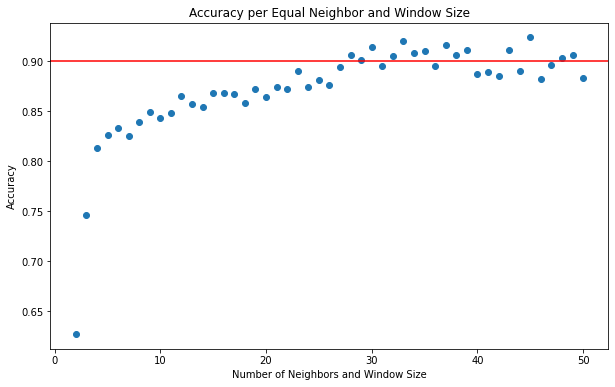

In [10]:
x = []
y = []
for i in range(2,51):
    outliers = windowOutlierDetection(DJdf.to_numpy(), i, i)
    falsePositives = outliers.size
    dataSize = DJdf.size/2
    x.append(i)
    y.append((dataSize-falsePositives)/dataSize)
plt.figure(figsize=(10,6))
plt.scatter(x,y)
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.title('Accuracy per Equal Neighbor and Window Size')
plt.xlabel('Number of Neighbors and Window Size')
plt.ylabel('Accuracy');
best = np.argmax(y)
print('Best: {:.1%} at {} neighbors and window size'.format(y[best], x[best]))

False Positives: 193
Accuracy: 92.4%


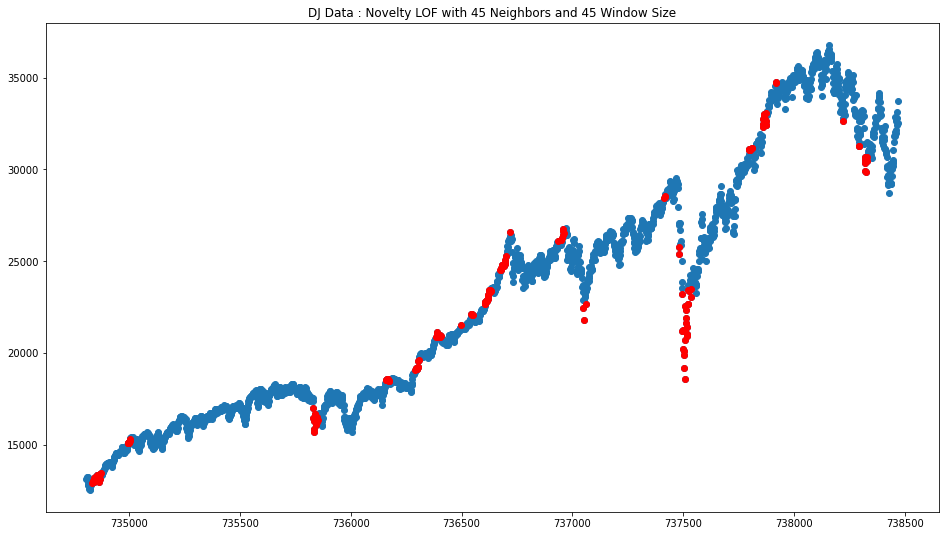

In [16]:
bestN = x[best]
outliers = windowOutlierDetection(DJdf.to_numpy(), bestN, bestN, delete=False)
graphDJOutliers(DJdf, outliers, bestN, title='DJ Data : Novelty LOF with {} Neighbors and {} Window Size'.format(bestN, bestN))
falsePositives = outliers.size
dataSize = DJdf.size/2
print('False Positives: {}'.format(falsePositives))
print('Accuracy: {0:.1%}'.format((dataSize-falsePositives)/dataSize))

# Tests

## Randomly Adjusted Data

70 Outliers Detected. 24 True Postiives, 46 False Positives
Accuracy of 0.9517022961203484


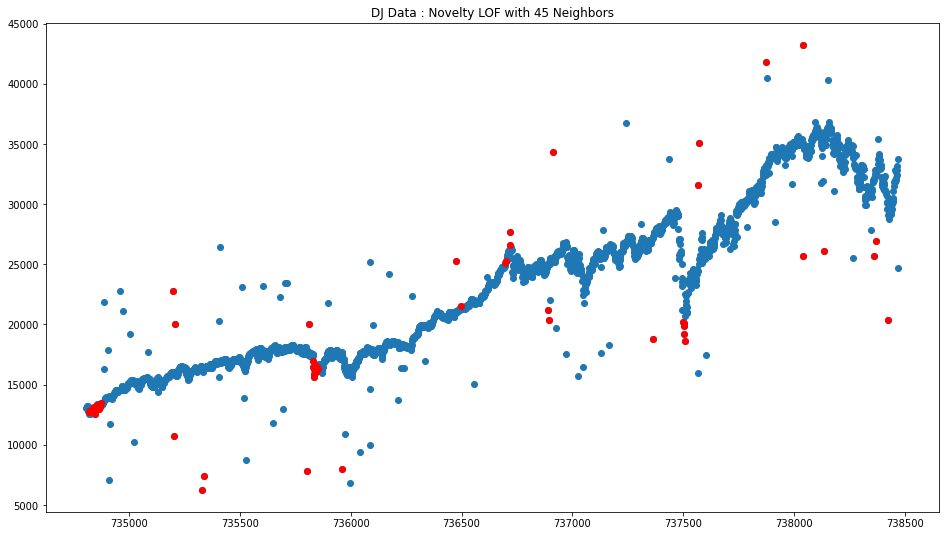

In [20]:
poisonCount = 100
adjustableRange = 10000
dataSize = int(DJdf.size/2)
poison = np.sort(random.sample(range(dataSize), poisonCount))
djCopy = DJdf.to_numpy()
for point in poison:
    djCopy[point,1] += random.uniform(-1 * adjustableRange, adjustableRange)
outliers = windowOutlierDetection(djCopy, 45, 45)
detected = outliers.size
positives = set(outliers)
truePositives = len(positives.intersection(set(poison)))
falsePositives = detected-truePositives
print('{} Outliers Detected. {} True Postiives, {} False Positives'.format(detected, truePositives, falsePositives))
print('Accuracy of {}'.format((truePositives + (dataSize - poisonCount - falsePositives))/dataSize))
graphDJOutliersNP(djCopy, outliers, 45)